# Extract autopi trials

We need to get behavioral data into a format that we can correlate to the ephys data.

We will extract trials, journeys and NavPaths. 

The NavPaths are small segments of behavior (e.g., search from arena entry to lever, search to lever press, etc.).

We get the instantaneous behavioral variables (distance run, time in the navPath, speed, etc) for each time point of the navPaths.

The main difference with the behavior_2021 project is that the position data comes from positrack (LED tracking) rather than from DLC.

We had to write a new TrialElectro and JourneyElectro class in the autopipy package for this.

Here is a list of files that are important for this process

We adjusted how the lever distance was calculated. The calculations of the NavPath objects (which is the distance from a single point) is overwritten in the Journey objects code (distance from the lever box). 


## Main output files

We save these files for later analysis in the data directory of each session.

* `trialsWithJourneys.pdf`
* `navPathSummary.csv` (about 900 lines)
* `navPathInstan.csv` (about 150000 lines)

We also save the myProject object as a pickle. This can be loaded later instead of always re-running the analysis.

* `/repo/autopi_analysis/Jazi_et.al_2023/trials/myProjectWithTrials.pickle`



## Note on position tracking

We need to have very good tracking on the arena without too many missing values. We applied a gh filter to improve the situation for some sessions.


In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

In [2]:
%load_ext autoreload
%autoreload 2

%run ../setup_project.py
%run ../neuronAutopi.py

prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy") # use the output of the kalman filter

data path: /d80/Jazi_etal_2023_noInter
Project name: autopi_ca1
dataPath: /d80/Jazi_etal_2023_noInter/autopi_ca1
Reading /d80/Jazi_etal_2023_noInter/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:21<00:00,  1.80it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


## Creating a list of TrialElectro

`TrialElectro` is a class in `autopipy` that is very similar to the `Trial` class that was developed for the behavioral experiment. The main difference is that it is adapted the spatial data coming from electrophysiology experiments. A TrialElectro object has a JourneyList which are JourneyElectro objects. The JourneyElectro objects have a dictionary of paths.


In [3]:
def extractNavPath(ses,sSes,verbose=False):
    
    loadTrials(ses,sSes)
    print("Trials: ", ses.nTrials, " Journeys:", ses.nJourneys)

    #This summary DataFrame can be used to select NavPaths that we want to analyze. The column "name" can be used to get the the instantaneous data for analysis with electrophysiological data.
    #It contains the time intervals to limit our spikeA.SpikeTrain to specific intervals. 
    #There are 2 functions in setup projects to transform ROS to res time (`RosToResTime()`and `resToRosTime()`).
    navPathSummary = ses.navPathIntervals()
    navPathSummary["startTimeRes"] = RosToResTime(navPathSummary.startTimeRos,np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1))
    navPathSummary["endTimeRes"] = RosToResTime(navPathSummary.endTimeRos,np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1))
    navPathSummary
    fn = ses.path+"/navPathSummary.csv"
    print("saving",fn)
    navPathSummary.to_csv(fn,index=False)


    # this is data with the instantaneous variables (variables evolving during navPath (distance to target, time, etc.)
    navPathInstan = ses.navPathInstantaneousBehavioralData()
    #navPathInstan["timeRes"] = RosToResTime(navPathInstan.timeRos,np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1))
    navPathInstan
    fn = ses.path+"/navPathInstan.csv"
    print("saving",fn)
    navPathInstan.to_csv(fn,index=False)
    
    # save the session object
    fn=ses.path+"/ses.pickle"
    print("Saving:",fn)
    with open(fn, 'wb') as handle:
        pickle.dump(ses, handle)


In [4]:
def loadTrials(ses,sSes):
    ## create a list of autopipy.Trial objects
    ses.segmentTrialsFromLog()
    ses.createTrialElectroList() # create a List of TrialElectro object
    ses.loadLogFile()
    ses.extractTrialElectroFeatures(sSes.ap.pose,verbose=False) # this will give us a list of ElectroTrials
    print(ses.nTrials, ses.nJourneys)

## Run the fun on single session

In [5]:
i=0
ses = myProject.sessionList[i]
sSes = sSesList[i]
ses.path                              

ses.segmentTrialsFromLog()
ses.createTrialElectroList() # create a List of TrialElectro object
ses.loadLogFile()

mn5824-20112020-0107 trial segmentation
Remove last opening of the door
Number of trials : 152


In [6]:
myProject.dataPath

'/d80/Jazi_etal_2023_noInter/autopi_ca1'

In [7]:
%%time
np.seterr(invalid='ignore')
ses.extractTrialElectroFeatures(sSes.ap.pose,verbose=False) # this will give us a list of ElectroTrials

leverZoneMaxDistance calculation
reading /d80/Jazi_etal_2023_noInter/autopi_ca1/mn5824/mn5824-20112020-0107/leverZoneMaxDistance
leverZoneMaxDistance: 10.0
no bridge time; no adjustTrialStart
mn5824-20112020-0107_1, no mouse position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, the mouse was detected for fewer than 20 frames during the trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever press or no mouse position
mn5824-20112020-0107_1, self.valid set to False


/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)


mn5824-20112020-0107_7, position of the animal at first lever press unknown
mn5824-20112020-0107_7, self.valid set to False
mn5824-20112020-0107_9, position of the animal at first lever press unknown
mn5824-20112020-0107_9, self.valid set to False
No time on the arena, can't cut at last arena bridge transition
trialNo: 34, journeyNo: 0, not time on the arena, we will only have a `all` navPath
No time on the arena, can't cut at last arena bridge transition
trialNo: 34, journeyNo: 1, not time on the arena, we will only have a `all` navPath
Could not find a homingPath in j.navPaths.keys()
Could not find a searchToLeverPath in j.navPaths.keys()
mn5824-20112020-0107_51, start time adjustment: -18.4626 sec
{}, start time adjustment would be too large, something is wrong.
keep original start time
mousePose.shape[0] for a navPath in 0 in journeyElectro.createNavPath
We have a None navPath in our dictionary, only keeping the all path
Could not find a homingPath in j.navPaths.keys()
Could not fi

dict_keys(['all', 'searchPath', 'searchToLeverPath', 'homingPath', 'homingFromLeavingLever', 'homingFromLeavingLeverToPeriphery', 'atLever'])

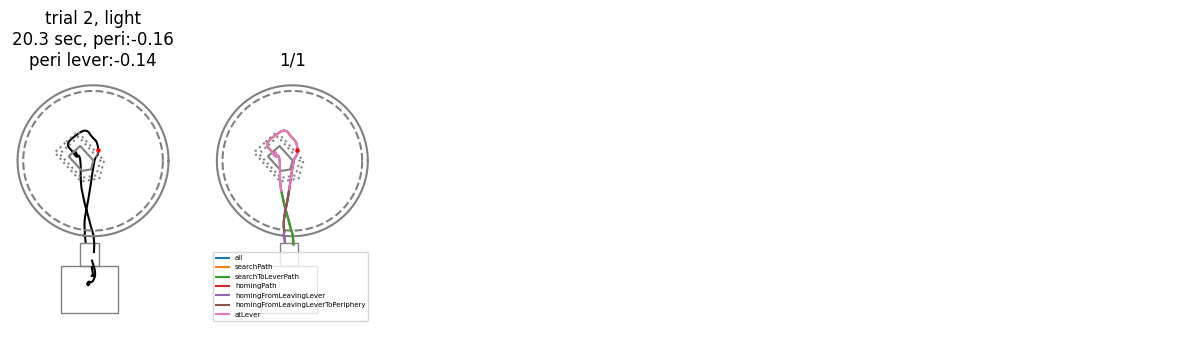

In [8]:
t = ses.trialList[1]
fig,ax = plt.subplots(1,6,figsize=(15,4))
t.plotTrialAndJourneys(ax)
j = t.journeyList[-1]
j.navPaths.keys()

Angle of entry to the lever zone

## Run on all sessions

## loadTrials

This saves `myProjectWithTrials.pkl`

In [9]:
%%time
for i,(ses,sSes) in enumerate(zip(myProject.sessionList[:],sSesList[:])):
    print(i,ses.name,sSes.name)
    #loadTrials(ses,sSes)
    extractNavPath(ses,sSes)

0 mn5824-20112020-0107 mn5824-20112020-0107
mn5824-20112020-0107 trial segmentation
Remove last opening of the door
Number of trials : 152
leverZoneMaxDistance calculation
reading /d80/Jazi_etal_2023_noInter/autopi_ca1/mn5824/mn5824-20112020-0107/leverZoneMaxDistance
leverZoneMaxDistance: 10.0
no bridge time; no adjustTrialStart
mn5824-20112020-0107_1, no mouse position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, the mouse was detected for fewer than 20 frames during the trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever press or no mouse position
mn5824-20112020-0107_1, self.valid set to False


/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)


mn5824-20112020-0107_7, position of the animal at first lever press unknown
mn5824-20112020-0107_7, self.valid set to False
mn5824-20112020-0107_9, position of the animal at first lever press unknown
mn5824-20112020-0107_9, self.valid set to False
No time on the arena, can't cut at last arena bridge transition
trialNo: 34, journeyNo: 0, not time on the arena, we will only have a `all` navPath
No time on the arena, can't cut at last arena bridge transition
trialNo: 34, journeyNo: 1, not time on the arena, we will only have a `all` navPath
Could not find a homingPath in j.navPaths.keys()
Could not find a searchToLeverPath in j.navPaths.keys()
mn5824-20112020-0107_51, start time adjustment: -18.4626 sec
{}, start time adjustment would be too large, something is wrong.
keep original start time
mousePose.shape[0] for a navPath in 0 in journeyElectro.createNavPath
We have a None navPath in our dictionary, only keeping the all path
Could not find a homingPath in j.navPaths.keys()
Could not fi

/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)
/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)
/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)
/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead o

saving /d80/Jazi_etal_2023_noInter/autopi_ca1/mn2739/mn2739-16022021-0106/navPathSummary.csv
saving /d80/Jazi_etal_2023_noInter/autopi_ca1/mn2739/mn2739-16022021-0106/navPathInstan.csv
Saving: /d80/Jazi_etal_2023_noInter/autopi_ca1/mn2739/mn2739-16022021-0106/ses.pickle
14 mn2739-17022021-0106 mn2739-17022021-0106
mn2739-17022021-0106 trial segmentation
Number of trials : 134
leverZoneMaxDistance calculation
reading /d80/Jazi_etal_2023_noInter/autopi_ca1/mn2739/mn2739-17022021-0106/leverZoneMaxDistance
leverZoneMaxDistance: 8.75
mn2739-17022021-0106_8, position of the animal at first lever press unknown
mn2739-17022021-0106_8, self.valid set to False
mn2739-17022021-0106_58, start time adjustment: -16.3233 sec
{}, start time adjustment would be too large, something is wrong.
keep original start time
mn2739-17022021-0106_58, add a journey missed because of no brige time before first arenaCenter
mn2739-17022021-0106_82, position of the animal at first lever press unknown
mn2739-17022021-

We can save the myProject (autopipy) session for later use. The size is approximately 5 Gb.

In [10]:
fn="/ext_drives/d80/Jazi_etal_2023/autopi_ca1/results/myProjectWithTrials.pickle"
print("Saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myProject, handle)


Saving: /ext_drives/d80/Jazi_etal_2023/autopi_ca1/results/myProjectWithTrials.pickle


## function extractNavPath(ses,sSes) will generate the following files.

* trialsWithJourneys.csv
* navPathSummary.csv
* navPathInstan.csv

We will reload the myProjectWithTrials here so that you don't need to run the code above to run the code below

In [10]:
%load_ext autoreload
%autoreload 2
%run  ~/repo/autopi_analysis_bk/Jazi_et.al_2023/setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project name: autopi_ca1
dataPath: /ext_drives/d80/Jazi_etal_2023/autopi_ca1
dlcModelPath: /adata/models
Reading /ext_drives/d80/Jazi_etal_2023/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:22<00:00,  1.77it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [13]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)


Loading: /ext_drives/d80/Jazi_etal_2023/autopi_ca1/results/myProjectWithTrials.pickle
CPU times: user 4.99 s, sys: 1.47 s, total: 6.45 s
Wall time: 6.46 s


In [14]:
myProjectWithTrials.dataPath

'/ext_drives/d80/Jazi_etal_2023/autopi_ca1'

In [15]:
for i,(ses,sSes) in enumerate(zip(myProject.sessionList[:],sSesList[:])):
    print(i,ses.name,sSes.name)
    extractNavPath(ses,sSes)

0 mn5824-20112020-0107 mn5824-20112020-0107
mn5824-20112020-0107 trial segmentation
Remove last opening of the door
Number of trials : 152
leverZoneMaxDistance calculation
reading /ext_drives/d80/Jazi_etal_2023/autopi_ca1/mn5824/mn5824-20112020-0107/leverZoneMaxDistance
leverZoneMaxDistance: 10.0
no bridge time; no adjustTrialStart
mn5824-20112020-0107_1, no mouse position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, the mouse was detected for fewer than 20 frames during the trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever position data during this trial
mn5824-20112020-0107_1, self.valid set to False
mn5824-20112020-0107_1, no lever press or no mouse position
mn5824-20112020-0107_1, self.valid set to False


/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)


mn5824-20112020-0107_7, position of the animal at first lever press unknown
mn5824-20112020-0107_7, self.valid set to False
mn5824-20112020-0107_9, position of the animal at first lever press unknown
mn5824-20112020-0107_9, self.valid set to False
No time on the arena, can't cut at last arena bridge transition
trialNo: 34, journeyNo: 0, not time on the arena, we will only have a `all` navPath
No time on the arena, can't cut at last arena bridge transition
trialNo: 34, journeyNo: 1, not time on the arena, we will only have a `all` navPath
Could not find a homingPath in j.navPaths.keys()
Could not find a searchToLeverPath in j.navPaths.keys()
mn5824-20112020-0107_51, start time adjustment: -18.4626 sec
{}, start time adjustment would be too large, something is wrong.
keep original start time
mousePose.shape[0] for a navPath in 0 in journeyElectro.createNavPath
We have a None navPath in our dictionary, only keeping the all path
Could not find a homingPath in j.navPaths.keys()
Could not fi

/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)
/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)
/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positionZones["loca"] = self.positionZones.iloc[:, :].idxmax(1)
/home/maryam/repo/autopipy/autopipy/trialElectro.py:432: FutureWarning: The default dtype for empty Series will be 'object' instead o

saving /ext_drives/d80/Jazi_etal_2023/autopi_ca1/mn2739/mn2739-16022021-0106/navPathSummary.csv
saving /ext_drives/d80/Jazi_etal_2023/autopi_ca1/mn2739/mn2739-16022021-0106/navPathInstan.csv
Saving: /ext_drives/d80/Jazi_etal_2023/autopi_ca1/mn2739/mn2739-16022021-0106/ses.pickle
14 mn2739-17022021-0106 mn2739-17022021-0106
mn2739-17022021-0106 trial segmentation
Number of trials : 134
leverZoneMaxDistance calculation
reading /ext_drives/d80/Jazi_etal_2023/autopi_ca1/mn2739/mn2739-17022021-0106/leverZoneMaxDistance
leverZoneMaxDistance: 8.75
mn2739-17022021-0106_8, position of the animal at first lever press unknown
mn2739-17022021-0106_8, self.valid set to False
mn2739-17022021-0106_58, start time adjustment: -16.3233 sec
{}, start time adjustment would be too large, something is wrong.
keep original start time
mn2739-17022021-0106_58, add a journey missed because of no brige time before first arenaCenter
mn2739-17022021-0106_82, position of the animal at first lever press unknown
mn27

Function to plot a single trial 

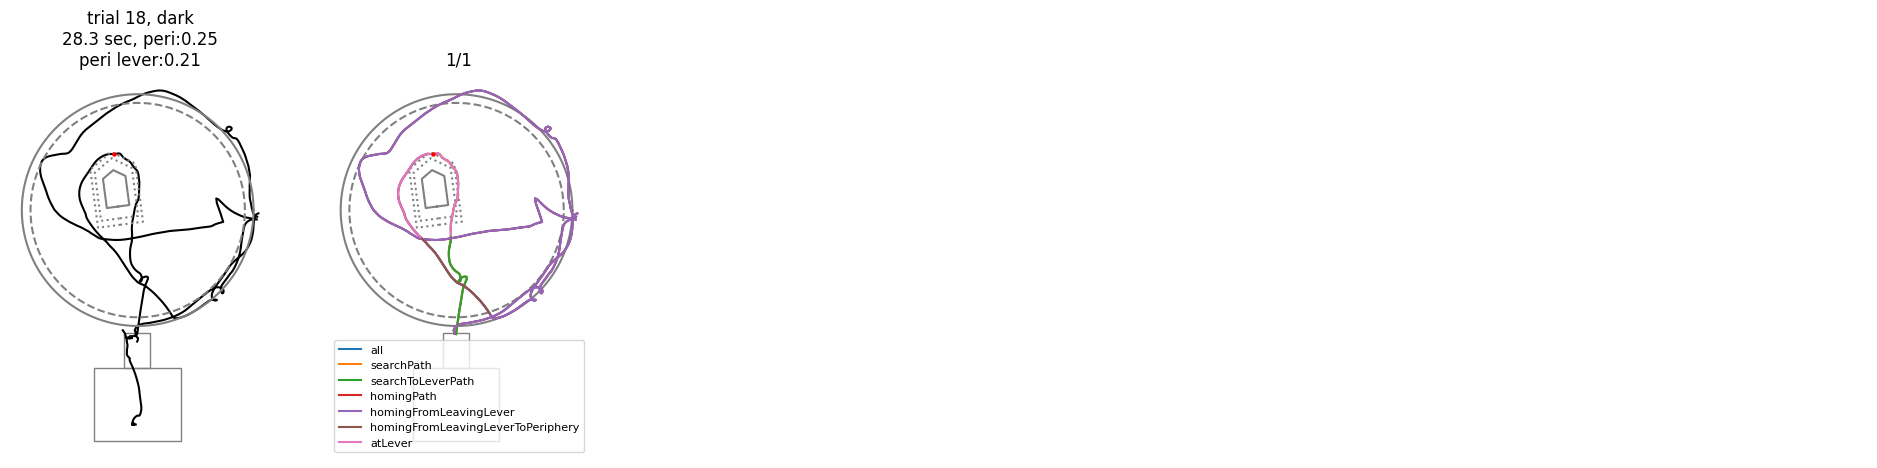

In [16]:
trial = ses.trialList[17]
fig, axes = plt.subplots(1,6,figsize=(4*6,5))
trial.plotTrialAndJourneys(axes,legendSize=8)

In [17]:
fn = ses.path+"/navPathSummary.csv"
pd.read_csv(fn)

,name,trial,trialNo,journey,type,light,nLeverPresses,startTimeRos,endTimeRos,startTimeRes,endTimeRes
0,mn9686-01112021-0106_1-0_all,mn9686-01112021-0106_1,1,0,all,light,1,1.635781e+09,1.635781e+09,3057.72,3066.90
1,mn9686-01112021-0106_1-0_searchPath,mn9686-01112021-0106_1,1,0,searchPath,light,1,1.635781e+09,1.635781e+09,3057.72,3065.70
2,mn9686-01112021-0106_1-0_searchToLeverPath,mn9686-01112021-0106_1,1,0,searchToLeverPath,light,1,1.635781e+09,1.635781e+09,3057.72,3065.04
3,mn9686-01112021-0106_1-0_homingPath,mn9686-01112021-0106_1,1,0,homingPath,light,1,1.635781e+09,1.635781e+09,3065.72,3066.90
4,mn9686-01112021-0106_1-0_homingFromLeavingLever,mn9686-01112021-0106_1,1,0,homingFromLeavingLever,light,1,1.635781e+09,1.635781e+09,3066.16,3066.90
...,...,...,...,...,...,...,...,...,...,...,...
1210,mn9686-01112021-0106_160-1_searchToLeverPath,mn9686-01112021-0106_160,160,1,searchToLeverPath,dark,1,1.635786e+09,1.635786e+09,8390.98,8391.16
1211,mn9686-01112021-0106_160-1_homingPath,mn9686-01112021-0106_160,160,1,homingPath,dark,1,1.635786e+09,1.635786e+09,8391.78,8393.80
1212,mn9686-01112021-0106_160-1_homingFromLeavingLever,mn9686-01112021-0106_160,160,1,homingFromLeavingLever,dark,1,1.635786e+09,1.635786e+09,8393.10,8393.80
1213,mn9686-01112021-0106_160-1_homingFromLeavingLe...,mn9686-01112021-0106_160,160,1,homingFromLeavingLeverToPeriphery,dark,1,1.635786e+09,1.635786e+09,8393.10,8393.22


In [18]:
navPathInstan = ses.navPathInstantaneousBehavioralData()
navPathInstan

,name,trialNo,timeRos,timeRes,iTime,iTimeProp,distance,distanceProp,speed,x,y,targetDistance,targetToAnimalX,targetToAnimalY,targetToAnimalAngle,cumSumDiffAngleAroundTarget
0,mn9686-01112021-0106_1-0_all,1,1.635781e+09,3057.72,0.000000,0.000000,0.226477,0.000939,10.469781,-1.547535,-42.772820,43.748974,-0.886454,-49.407187,-1.588736,NaN
1,mn9686-01112021-0106_1-0_all,1,1.635781e+09,3057.74,0.021631,0.002355,0.521394,0.002163,11.984293,-1.505792,-42.550224,43.525129,-0.844711,-49.184590,-1.587969,0.000767
2,mn9686-01112021-0106_1-0_all,1,1.635781e+09,3057.76,0.046240,0.005035,0.817749,0.003392,13.761295,-1.477743,-42.256644,43.230798,-0.816662,-48.891010,-1.587499,0.001238
3,mn9686-01112021-0106_1-0_all,1,1.635781e+09,3057.78,0.067775,0.007380,1.209617,0.005018,20.032589,-1.470911,-41.960367,42.934455,-0.809830,-48.594734,-1.587460,0.001276
4,mn9686-01112021-0106_1-0_all,1,1.635781e+09,3057.80,0.087337,0.009510,1.694762,0.007030,30.082162,-1.502748,-41.569795,42.545125,-0.841667,-48.204161,-1.588255,0.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,mn9686-01112021-0106_160-1_atLever,160,1.635786e+09,8393.02,1.858261,0.950462,64.690139,0.965279,35.879708,-18.847819,-25.363831,8.941222,-15.222911,-1.085322,-3.070418,4.739598
94,mn9686-01112021-0106_160-1_atLever,160,1.635786e+09,8393.04,1.879748,0.961452,65.473458,0.976967,36.726040,-18.781886,-26.131971,9.217626,-15.156978,-1.853462,-3.019912,4.790103
95,mn9686-01112021-0106_160-1_atLever,160,1.635786e+09,8393.06,1.901077,0.972361,66.251160,0.988572,36.775143,-18.668076,-26.906977,9.511755,-15.043168,-2.628468,-2.968611,4.841405
96,mn9686-01112021-0106_160-1_atLever,160,1.635786e+09,8393.08,1.922224,0.983178,67.017058,1.000000,23.287125,-18.505967,-27.667596,9.812199,-14.881058,-3.389087,-2.917667,4.892349
